## Using Vanilla CNN for baseline model prediction for Audio Classification tasks


### Data preprocessing step

Taken from first part of : https://github.com/krishnaik06/Audio-Classification/blob/main/Part%202-%20Audio%20Classification%20Data%20Preprocessing%20And%20Model%20Creation.ipynb


and

https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb


In [8]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import random
import torchaudio
import torchaudio.transforms as transforms


print('success')

success


## Mount GDRIVE


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
print(os.getcwd())

/content


In [11]:
# rileyqx1
!cp -a "/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/." "/content/"

cp: cannot open '/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/./Project Report.gdoc' for reading: Operation not supported


In [12]:
angry_path = './angry/'
disgusting_path = './disgusting/'
fear_path = './fear/'
happy_path = './happy/'
neutral_path = './neutral/'
sad_path = './sad/'


# Getting files into a list
from os import listdir
from os.path import isfile, join
angryfiles = [f for f in listdir(angry_path) if isfile(join(angry_path, f))]
disgustingfiles = [f for f in listdir(disgusting_path) if isfile(join(disgusting_path, f))]
fearfiles = [f for f in listdir(fear_path) if isfile(join(fear_path, f))]
happyfiles = [f for f in listdir(happy_path) if isfile(join(happy_path, f))]
neutralfiles = [f for f in listdir(neutral_path) if isfile(join(neutral_path, f))]
sadfiles = [f for f in listdir(sad_path) if isfile(join(sad_path, f))]



## Preprocess and show on a plot

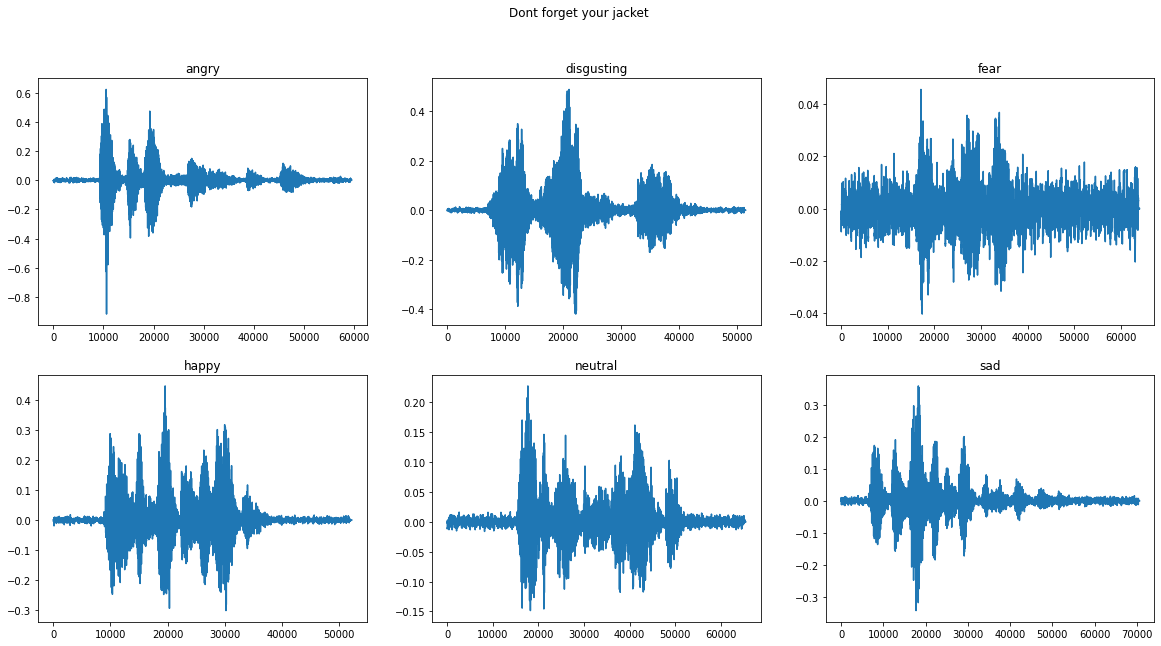

In [13]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate=librosa.load(angry_one)
disgusting_one = disgusting_path + disgustingfiles[0]
disgusting_audio_data,disgusting_sample_rate=librosa.load(disgusting_one)
fear_one = fear_path + fearfiles[0]
fear_audio_data,fear_sample_rate=librosa.load(fear_one)
happy_one = happy_path + happyfiles[0]
happy_audio_data,happy_sample_rate=librosa.load(happy_one)
neutral_one = neutral_path + neutralfiles[0]
neutral_audio_data,neutral_sample_rate=librosa.load(neutral_one)
sad_one = sad_path + sadfiles[0]
sad_audio_data,sad_sample_rate=librosa.load(sad_one)




plt.rcParams["figure.figsize"] = (20,10)
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry')
ax2.plot(disgusting_audio_data)
ax2.title.set_text('disgusting')
ax3.plot(fear_audio_data)
ax3.title.set_text('fear')
ax4.plot(happy_audio_data)
ax4.title.set_text('happy')
ax5.plot(neutral_audio_data)
ax5.title.set_text('neutral')
ax6.plot(sad_audio_data)
ax6.title.set_text('sad')

## Audio data augmentation 

In [14]:
# time shift
def time_shift(aud, shift_limit):
  sig_len = aud.shape[0]
  shift_amt = int(random.random() * shift_limit * sig_len)
  return torch.from_numpy(np.roll(aud,shift_amt))

# noising
def noising(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    return augmented_data

# pitch manipulation
def pitch_manipulate(data,sr, pitch_factor):
  data = torch.flatten(data)
  return torch.Tensor(librosa.effects.pitch_shift(np.array(data), sr, pitch_factor))

# speed manipulation
def speed_manipulate(data, speed_factor):
  data = torch.flatten(data)
  return torch.Tensor(librosa.effects.time_stretch(np.array(data), speed_factor))

### Spectrogram Augmentation 

In [15]:
def freq_mask(spec, F=188, num_masks=1):
    test = spec.clone()
    num_mel_channels = test.shape[2]
    for i in range(0, num_masks):        
        freq = random.randrange(1,10)
        zero = random.randrange(0, F - num_mel_channels)
        # avoids randrange error if values are equal and range is empty
        if (zero == zero + freq): return test
        mask_end = random.randrange(zero, zero + freq) 
        test[0][zero:mask_end] = test.mean()
    return test

def time_mask(spec, time=128, num_masks=1):
    test = spec.clone()
    length = test.shape[1]
    for i in range(0, num_masks):
        t = random.randrange(1,4)
        zero = random.randrange(0, length-time)
        if (zero == zero + t): return test
        mask_end = random.randrange(zero, zero + t)
        test[0][:,zero:mask_end] = test.mean()
    return test

## Display visualization in a spectogram

In [16]:
# Torch audio tensor to image
def tensor_to_img(spectrogram): 
    plt.imshow(spectrogram[0],aspect='auto', origin='lower')
    plt.show();
    display(spectrogram.shape)
    
def tfm_spectro(ad, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.

    data = ad[0]
    data = pad_trunc(data,sr,3000)

    # data = noising(data,100) # apply noising data augmentation, try noising the f out of this and see if the model can still learn
    # data = time_shift(data,2) # apply timeshift data augmentation
    # data = pitch_manipulate(data,sr,2) # apply pitch data augmentation
    # data = speed_manipulate(data,1.25) # apply speed data augmentation
    
    # cast dtype of tensor back to float32
    data = data.float()

    mel = transforms.MelSpectrogram(sample_rate=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(data.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension, mostly to look sane to a human.
    if to_db_scale: mel = transforms.AmplitudeToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

def pad_trunc(ad, sr, max_ms):
  sig_len = ad.shape[1]
  max_len = sr//1000 * max_ms # max len should always be 16000//1000 * 3000

  if (sig_len > max_len):
    # Truncate the signal to the given length
    ad = ad[:,:max_len]

      # process back to numpy array to be fed as input.

  elif (sig_len < max_len):
    # Length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len

    # Pad with 0s
    pad_begin = torch.zeros((1, pad_begin_len))
    pad_end = torch.zeros((1, pad_end_len))

    # print(pad_begin.shape,ad.shape,pad_end.shape)
    ad = torch.cat((pad_begin, ad, pad_end), 1)
      
  return ad

In [17]:
import librosa.display

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


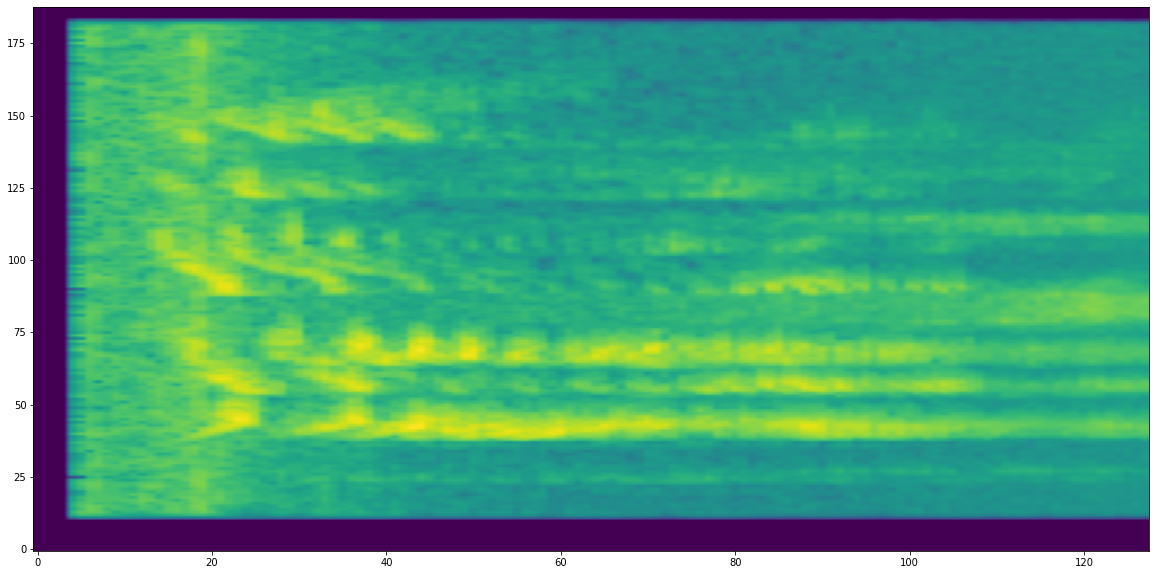

torch.Size([1, 188, 128])

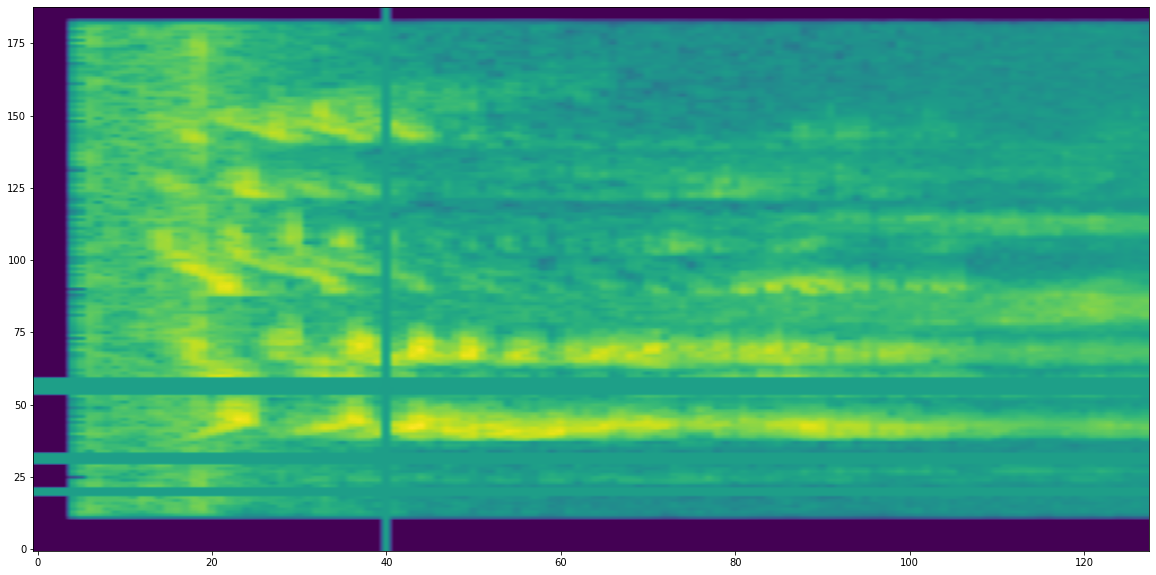

torch.Size([1, 188, 128])

In [18]:
angry = torchaudio.load(angry_one)
angry = tfm_spectro(angry, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80) # returns a spectrogram
tensor_to_img(angry) 
angry = freq_mask(angry,num_masks=5)
angry = time_mask(angry,num_masks=5)
tensor_to_img(angry)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


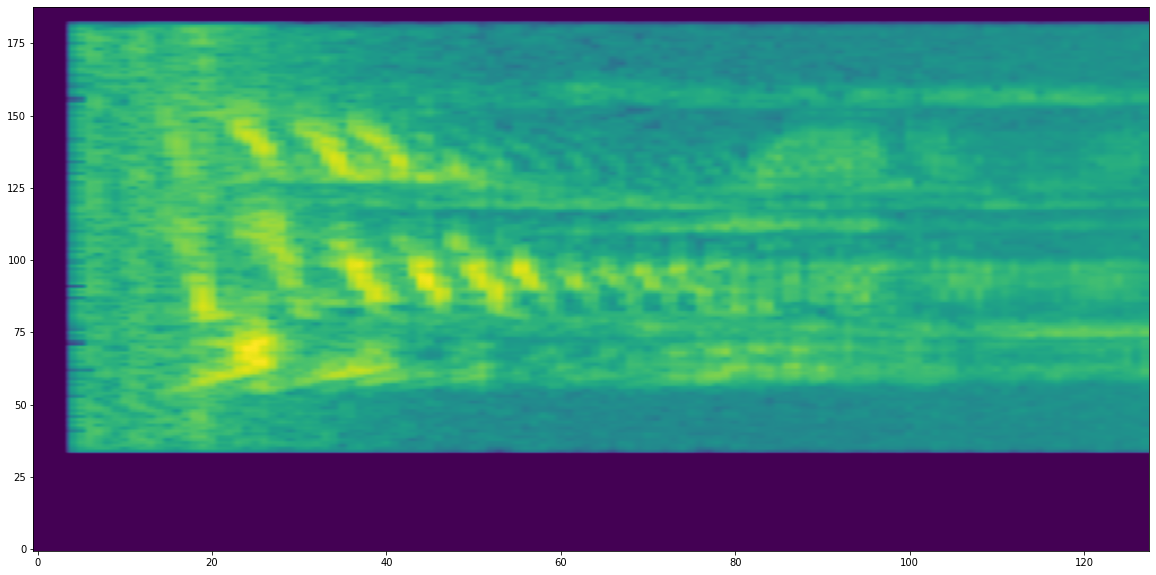

torch.Size([1, 188, 128])

In [19]:
disgusting = torchaudio.load(disgusting_one)
disgusting = tfm_spectro(disgusting, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(disgusting)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


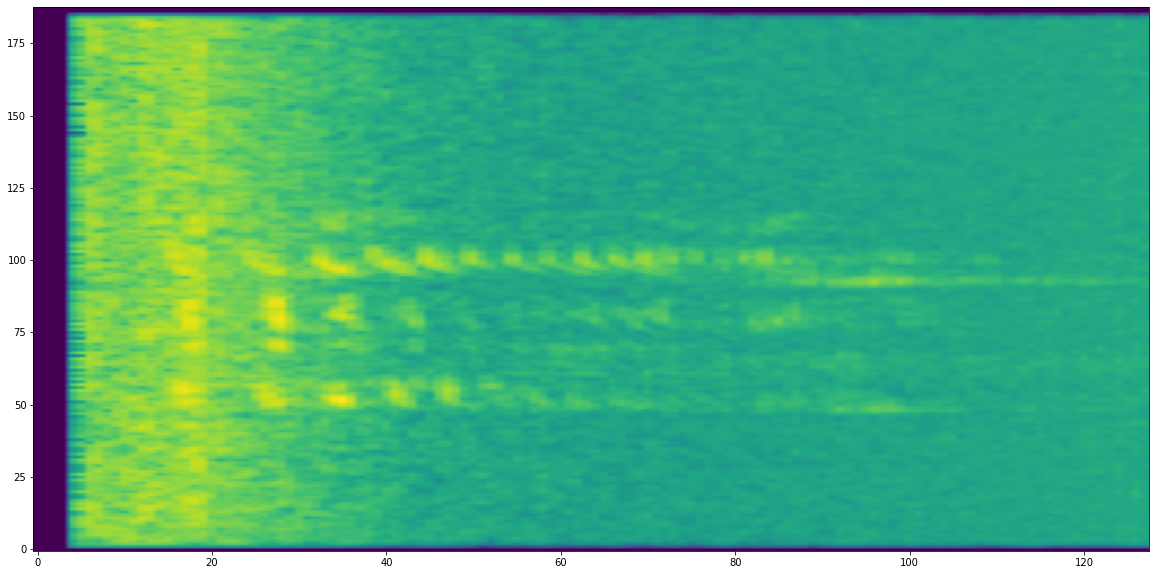

torch.Size([1, 188, 128])

In [20]:
fear = torchaudio.load(fear_one)
fear = tfm_spectro(fear, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(fear)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


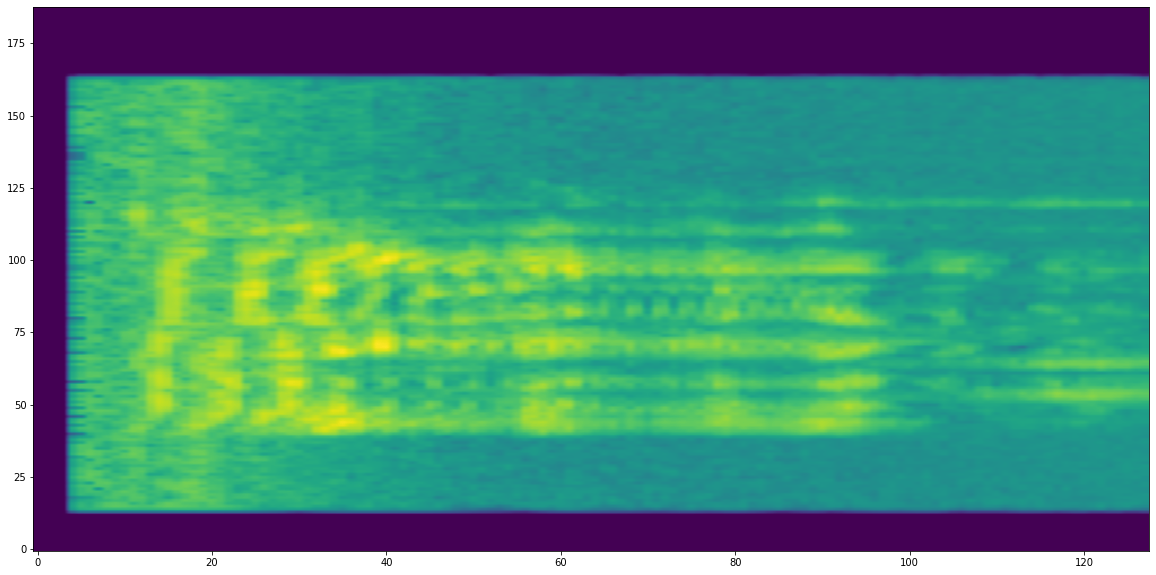

torch.Size([1, 188, 128])

In [21]:
happy = torchaudio.load(happy_one)
happy = tfm_spectro(happy, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(happy)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


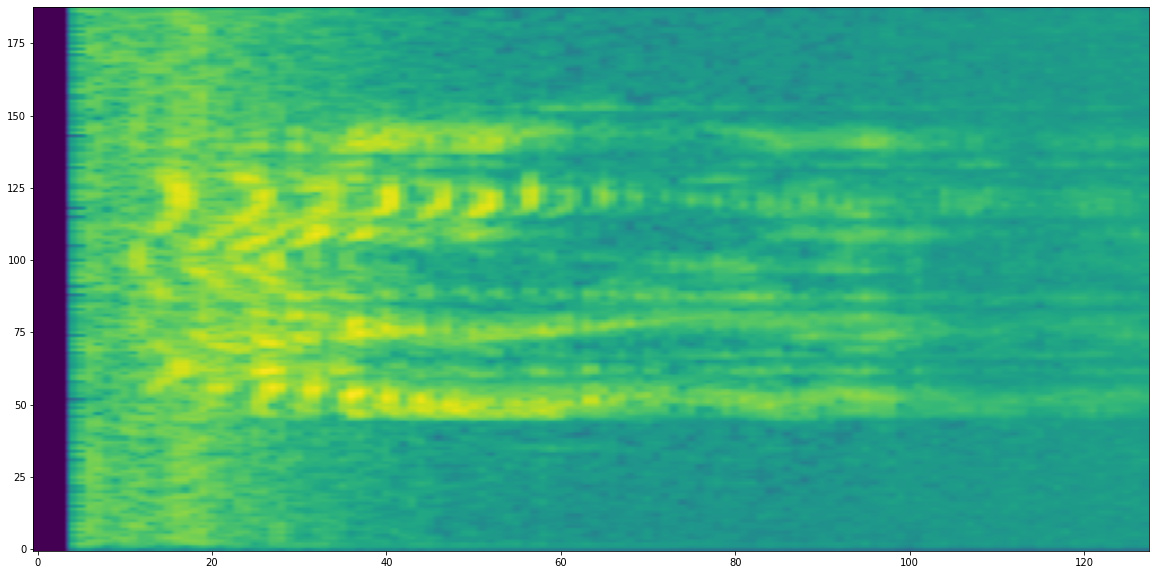

torch.Size([1, 188, 128])

In [22]:
neutral = torchaudio.load(neutral_one)
neutral = tfm_spectro(neutral, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(neutral)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


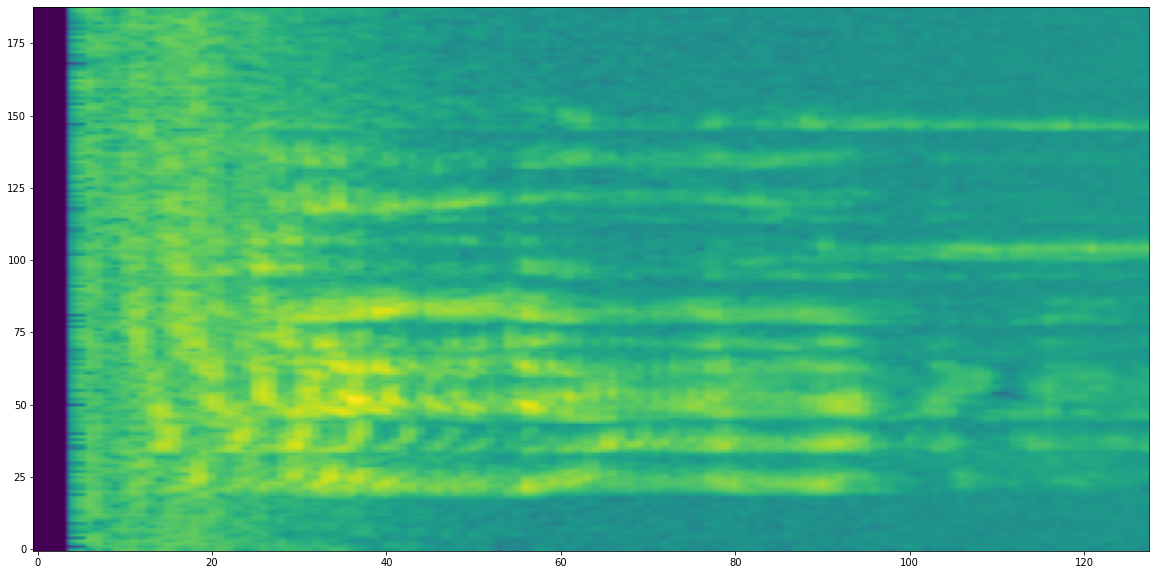

torch.Size([1, 188, 128])

In [23]:
sad = torchaudio.load(sad_one)
sad = tfm_spectro(sad, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(sad)

# Create dataloaders

In [24]:
print(len(angryfiles),len(sadfiles),len(disgustingfiles),len(neutralfiles),len(fearfiles),len(happyfiles))

1087 1087 1087 1087 1087 1087


In [25]:
# This will take awhile
data = []
all_files = [angryfiles,sadfiles,disgustingfiles,neutralfiles,fearfiles,happyfiles]
all_paths = ['angry','sad','disgusting','neutral','fear','happy']
all_directories = [angry_path,sad_path,disgusting_path,neutral_path,fear_path,happy_path]

for i in range(len(all_files)):
    for j in range(len(all_files[i])):
        data.append([all_files[i][j],all_paths[i]])

data = pd.DataFrame(data,columns=['name','class'])

In [26]:
print(data)

                     name  class
0     1028_ITS_ANG_XX.wav  angry
1     1024_IEO_ANG_LO.wav  angry
2     1063_TAI_ANG_XX.wav  angry
3     1042_IWW_ANG_XX.wav  angry
4     1003_TAI_ANG_XX.wav  angry
...                   ...    ...
6517  1074_IEO_HAP_HI.wav  happy
6518  1019_TAI_HAP_XX.wav  happy
6519  1006_IWW_HAP_XX.wav  happy
6520  1067_ITH_HAP_XX.wav  happy
6521  1067_IOM_HAP_XX.wav  happy

[6522 rows x 2 columns]


In [27]:
class AudioData(Dataset):
  def __init__(self, df):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(['angry','sad','disgusting','neutral','fear','happy'])
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = './' + row['class'] + '/' + row['name']


      # LOADING DATA HERE, apply data augmentation here if needed
      data = torchaudio.load(file_path) 
      spectro = tfm_spectro(data, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
      # spectro = freq_mask(spectro,num_masks=20) # frequency data augmentation
      # spectro = time_mask(spectro,num_masks=20) # time data augmentation
      self.data.append(spectro)

      self.labels.append(self.c2i[row['class']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [30]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=0.2,shuffle = True)

In [31]:
train_data = AudioData(train)
valid_data = AudioData(valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/5217 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


  0%|          | 0/1305 [00:00<?, ?it/s]

In [32]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

## Setup torch for training 

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 # device = torch.device('cpu')
print(device)

seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

cuda:0


## Create the model

In [46]:
class CNN(nn.Module):
  def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1,4,kernel_size = 5, stride=1,padding=1)
      self.bn1 = nn.BatchNorm2d(4)
      self.conv2 = nn.Conv2d(4,8,kernel_size = 3, stride=1,padding=1)
      self.bn2 = nn.BatchNorm2d(8)
      self.conv3 = nn.Conv2d(8,16,kernel_size = 3,stride=1,padding=1)
      self.bn3 = nn.BatchNorm2d(16)
      self.dense1 = nn.Linear(16*23*15 ,500)
      self.dropout1 = nn.Dropout(0.5)
      self.dense2 = nn.Linear(500, 6)


  def forward(self, x):
      x = self.conv1(x)
      x = F.relu(self.bn1(x))
      x = self.conv2(x)
      x = F.avg_pool2d(x, kernel_size=2) # From 32 - 32
      x = F.relu(self.bn2(x))
      x = F.avg_pool2d(x, kernel_size=2) # From 32 - 32
      x = self.conv3(x)
      x = self.dropout1(x)
      x = F.relu(self.bn3(x))
      x = F.avg_pool2d(x, kernel_size=2) # From 32 - 32

      # print(x.shape)
      x = x.view(x.size(0),-1)
      x = self.dense1(x)
      x = self.dropout1(x)
      x = self.dense2(x)
      # return x
      return x

In [47]:
model = CNN()
model = model.cuda() # if GPU avail

## Set other parameters


1.   Vary different multi class loss functions
2.   Vary optimizer for faster reach of minimum loss



In [56]:
import torch.optim as optim

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0) # Set the original weight decay to 0, disable auto weight decay for SGD

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_accu = []
train_losses = []
eval_accu = []
eval_losses = []

In [57]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()
  
  running_loss=0
  correct=0
  total=0

  for data in tqdm(train_loader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    inputs,label=inputs.cuda(),labels.cuda()
    
    outputs=model(inputs.float())

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.cuda()

    loss = criterion(outputs,labels)

    ################ MANUAL REGULARISATION ###################

    #Replace pow(2.0) with abs() for L1 regularization
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm

    ###################################################

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)

    # print(labels,predicted) # Checking the ground truths
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [58]:
def test(epoch):
  print('\nEpoch : %d'%epoch)
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(valid_loader):
      inputs,labels=data[0].to(device),data[1].to(device)
      inputs,label=inputs.cuda(),labels.cuda()
      
      outputs=model(inputs.float())

      criterion = nn.CrossEntropyLoss()
      criterion = criterion.cuda()
      
      loss= criterion(outputs,labels)

      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(valid_loader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [59]:
epochs=50
patience = 5

count = 0
previous_loss = 100
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)
  print("best test accuracy =",max(eval_accu))

  # Naive implementation of early stop
  if eval_losses[-1]>previous_loss:
    count+=1
    if count>patience:
      del train_losses[-patience:]
      del train_accu[-patience:]
      del eval_losses[-patience:]
      del eval_accu[-patience:]
      break

  else:
    count=0
    PATH = './model.pth'
    torch.save(model, PATH)

  if epoch==epochs:
    PATH = './model.pth'
    torch.save(model, PATH)

  previous_loss = eval_losses[-1]


Epoch : 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.438 | Accuracy: 46.310

Epoch : 1


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.426 | Accuracy: 41.609
best test accuracy = 41.60919540229885

Epoch : 2


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.207 | Accuracy: 53.671

Epoch : 2


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.375 | Accuracy: 43.218
best test accuracy = 43.2183908045977

Epoch : 3


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.137 | Accuracy: 56.527

Epoch : 3


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.419 | Accuracy: 46.437
best test accuracy = 46.4367816091954

Epoch : 4


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.114 | Accuracy: 58.827

Epoch : 4


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.495 | Accuracy: 42.529
best test accuracy = 46.4367816091954

Epoch : 5


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.060 | Accuracy: 60.399

Epoch : 5


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.452 | Accuracy: 43.525
best test accuracy = 46.4367816091954

Epoch : 6


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.035 | Accuracy: 61.146

Epoch : 6


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.408 | Accuracy: 49.349
best test accuracy = 49.348659003831415

Epoch : 7


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 1.001 | Accuracy: 63.331

Epoch : 7


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.289 | Accuracy: 50.958
best test accuracy = 50.95785440613027

Epoch : 8


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.989 | Accuracy: 63.159

Epoch : 8


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.376 | Accuracy: 45.670
best test accuracy = 50.95785440613027

Epoch : 9


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.955 | Accuracy: 64.922

Epoch : 9


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.266 | Accuracy: 49.732
best test accuracy = 50.95785440613027

Epoch : 10


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.959 | Accuracy: 64.999

Epoch : 10


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.332 | Accuracy: 49.195
best test accuracy = 50.95785440613027

Epoch : 11


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.936 | Accuracy: 65.497

Epoch : 11


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.512 | Accuracy: 42.835
best test accuracy = 50.95785440613027

Epoch : 12


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.916 | Accuracy: 66.858

Epoch : 12


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.272 | Accuracy: 51.801
best test accuracy = 51.8007662835249

Epoch : 13


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.893 | Accuracy: 68.162

Epoch : 13


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.324 | Accuracy: 49.195
best test accuracy = 51.8007662835249

Epoch : 14


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.888 | Accuracy: 67.184

Epoch : 14


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.344 | Accuracy: 49.808
best test accuracy = 51.8007662835249

Epoch : 15


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.868 | Accuracy: 68.641

Epoch : 15


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.329 | Accuracy: 49.195
best test accuracy = 51.8007662835249

Epoch : 16


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.844 | Accuracy: 69.005

Epoch : 16


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.745 | Accuracy: 41.379
best test accuracy = 51.8007662835249

Epoch : 17


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.859 | Accuracy: 68.449

Epoch : 17


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.361 | Accuracy: 48.736
best test accuracy = 51.8007662835249

Epoch : 18


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.831 | Accuracy: 70.117

Epoch : 18


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.340 | Accuracy: 49.119
best test accuracy = 51.8007662835249

Epoch : 19


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.797 | Accuracy: 71.919

Epoch : 19


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.277 | Accuracy: 52.031
best test accuracy = 52.030651340996165

Epoch : 20


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.777 | Accuracy: 71.976

Epoch : 20


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.434 | Accuracy: 49.655
best test accuracy = 52.030651340996165

Epoch : 21


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.793 | Accuracy: 71.746

Epoch : 21


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.303 | Accuracy: 49.808
best test accuracy = 52.030651340996165

Epoch : 22


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.753 | Accuracy: 73.663

Epoch : 22


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.314 | Accuracy: 51.724
best test accuracy = 52.030651340996165

Epoch : 23


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.760 | Accuracy: 72.935

Epoch : 23


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.560 | Accuracy: 42.989
best test accuracy = 52.030651340996165

Epoch : 24


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.750 | Accuracy: 72.417

Epoch : 24


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.305 | Accuracy: 51.418
best test accuracy = 52.030651340996165

Epoch : 25


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.742 | Accuracy: 73.241

Epoch : 25


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.452 | Accuracy: 49.808
best test accuracy = 52.030651340996165

Epoch : 26


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.729 | Accuracy: 74.181

Epoch : 26


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.370 | Accuracy: 48.429
best test accuracy = 52.030651340996165

Epoch : 27


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.728 | Accuracy: 73.797

Epoch : 27


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.415 | Accuracy: 48.429
best test accuracy = 52.030651340996165

Epoch : 28


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.732 | Accuracy: 73.874

Epoch : 28


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.355 | Accuracy: 50.115
best test accuracy = 52.030651340996165

Epoch : 29


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.723 | Accuracy: 73.989

Epoch : 29


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.260 | Accuracy: 52.567
best test accuracy = 52.56704980842912

Epoch : 30


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.710 | Accuracy: 74.621

Epoch : 30


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.372 | Accuracy: 49.732
best test accuracy = 52.56704980842912

Epoch : 31


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.698 | Accuracy: 75.580

Epoch : 31


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.312 | Accuracy: 49.349
best test accuracy = 52.56704980842912

Epoch : 32


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.675 | Accuracy: 76.787

Epoch : 32


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.400 | Accuracy: 49.655
best test accuracy = 52.56704980842912

Epoch : 33


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.687 | Accuracy: 76.500

Epoch : 33


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.374 | Accuracy: 50.038
best test accuracy = 52.56704980842912

Epoch : 34


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.642 | Accuracy: 76.902

Epoch : 34


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.320 | Accuracy: 51.877
best test accuracy = 52.56704980842912

Epoch : 35


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.675 | Accuracy: 75.944

Epoch : 35


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.399 | Accuracy: 48.199
best test accuracy = 52.56704980842912

Epoch : 36


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.658 | Accuracy: 76.826

Epoch : 36


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.376 | Accuracy: 48.352
best test accuracy = 52.56704980842912

Epoch : 37


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.652 | Accuracy: 77.746

Epoch : 37


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.377 | Accuracy: 49.425
best test accuracy = 52.56704980842912

Epoch : 38


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.640 | Accuracy: 77.535

Epoch : 38


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.324 | Accuracy: 51.571
best test accuracy = 52.56704980842912

Epoch : 39


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.631 | Accuracy: 78.283

Epoch : 39


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.375 | Accuracy: 50.115
best test accuracy = 52.56704980842912

Epoch : 40


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.642 | Accuracy: 78.436

Epoch : 40


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.440 | Accuracy: 48.889
best test accuracy = 52.56704980842912

Epoch : 41


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.627 | Accuracy: 79.145

Epoch : 41


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.392 | Accuracy: 48.199
best test accuracy = 52.56704980842912

Epoch : 42


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.627 | Accuracy: 78.532

Epoch : 42


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.350 | Accuracy: 50.345
best test accuracy = 52.56704980842912

Epoch : 43


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.612 | Accuracy: 79.126

Epoch : 43


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.366 | Accuracy: 47.816
best test accuracy = 52.56704980842912

Epoch : 44


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.619 | Accuracy: 79.279

Epoch : 44


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.368 | Accuracy: 48.736
best test accuracy = 52.56704980842912

Epoch : 45


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.592 | Accuracy: 79.835

Epoch : 45


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.382 | Accuracy: 49.579
best test accuracy = 52.56704980842912

Epoch : 46


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.646 | Accuracy: 76.979

Epoch : 46


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.353 | Accuracy: 47.893
best test accuracy = 52.56704980842912

Epoch : 47


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.598 | Accuracy: 79.682

Epoch : 47


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.458 | Accuracy: 49.425
best test accuracy = 52.56704980842912

Epoch : 48


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.606 | Accuracy: 79.758

Epoch : 48


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.649 | Accuracy: 47.816
best test accuracy = 52.56704980842912

Epoch : 49


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.597 | Accuracy: 80.525

Epoch : 49


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.427 | Accuracy: 48.659
best test accuracy = 52.56704980842912

Epoch : 50


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.594 | Accuracy: 79.893

Epoch : 50


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.430 | Accuracy: 50.115
best test accuracy = 52.56704980842912


In [60]:
print('success')

success


## Plotting graphs to visualize loss

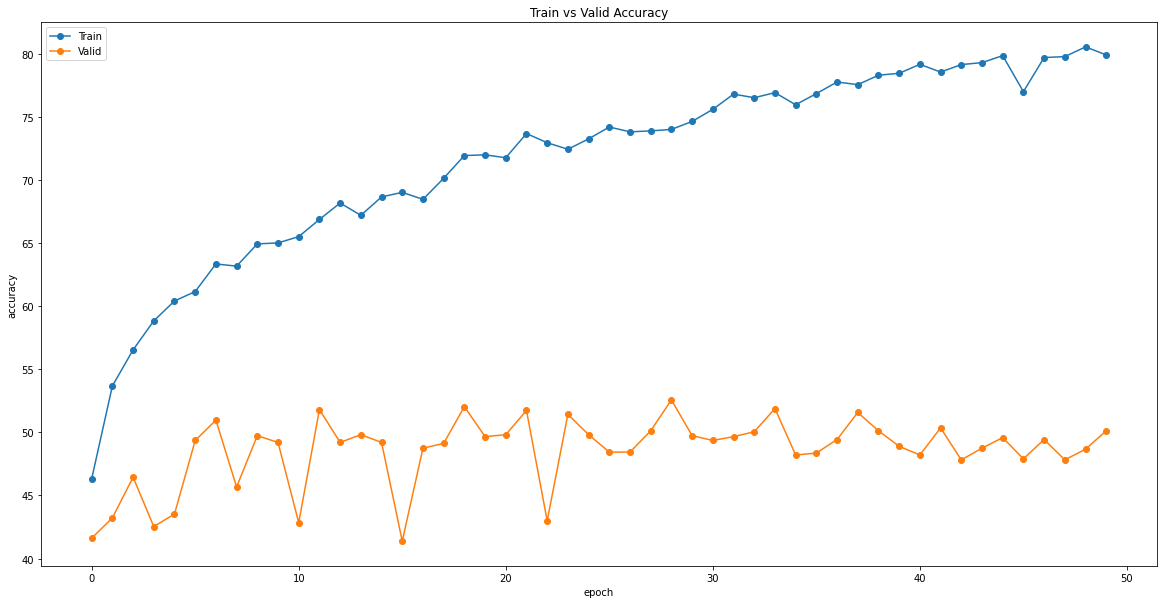

In [61]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

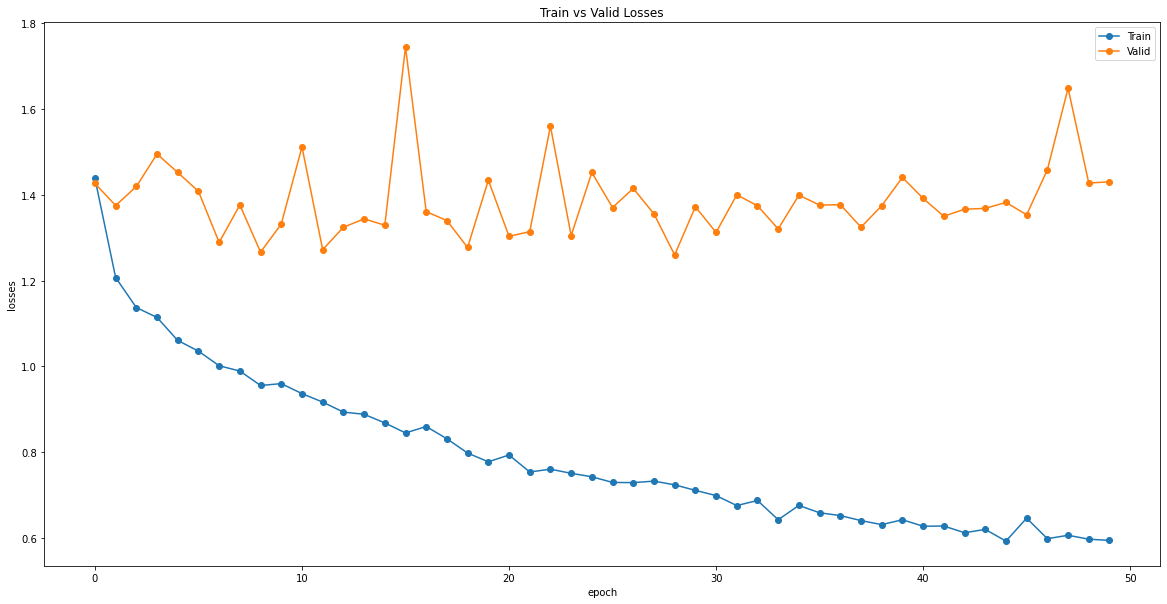

In [62]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

## Testing predictions

In [64]:
# labels = sorted(['angry','sad','disgusting','neutral','fear','happy'])
# print(labels)

# # riley = torch.load('./neutral/Recording.wav')
# aaa = torch.load('./neutral/1001_IEO_NEU_XX.wav')

# test_data = pd.DataFrame([['./1001_DFA_NEU_XX.wav','neutral']],columns=['name','class'])

# test_data = AudioData(test_data)

# test_loader = DataLoader(test_data, batch_size=1)

['angry', 'disgusting', 'fear', 'happy', 'neutral', 'sad']


UnpicklingError: ignored

In [ ]:
# model.eval()

# seed = 0
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)

# with torch.no_grad():
#   for data in tqdm(test_loader):
#     inputs,labels=data[0].to(device),data[1].to(device)
#     print(inputs.shape,labels)

#     outputs = model(inputs.float())
#     _, predicted = outputs.max(1)
#     classes = sorted(['angry','sad','disgusting','neutral','fear','happy'])
#     print(predicted,classes[predicted])